# Contributors
ΛΟΥΚΑΣ ΜΑΣΤΟΡΟΠΟΥΛΟΣ 1115 2017 00078 <br>
ΣΠΥΡΙΔΩΝ ΠΙΚΟΥΛΑΣ 1115 2014 000158

# 0.Imports

In [98]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive/ΤΕΔ/Main Branch/scr'
# path = 'C:/Users/diuoa/Desktop/pydata/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import nltk

In [100]:
train_df = pd.read_csv(path+'/data/train.csv')
test_df = pd.read_csv(path+'/data/test.csv')
target_df = pd.read_csv(path+'/data/target.csv')

# train_df = pd.read_csv(path+'train.csv')
# test_df = pd.read_csv(path+'test.csv')
# target_df = pd.read_csv(path+'target.csv')

test_df["trip_duration"] = target_df[target_df["id"] == test_df["id"]]["trip_duration"]
print("Nan of trip duration values for test: "+str(test_df["trip_duration"].isna().sum()))

Nan of trip duration values for test: 0


# 1.Ανάλυση Δεδομένων

In [101]:
print("Train dataset")
# Check for duplicate ids
print("Duplicated ids: " + str(train_df.duplicated(subset=["id"]).sum()))

# find NaN values
print("-Nan counts per column-")
for column in train_df.columns:
  print(column + ": " + str(train_df[column].isna().sum()))

Train dataset
Duplicated ids: 0
-Nan counts per column-
id: 0
vendor_id: 0
pickup_datetime: 0
dropoff_datetime: 0
passenger_count: 0
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 0
dropoff_latitude: 0
store_and_fwd_flag: 0
trip_duration: 0


In [102]:
print("Test dataset")
# Check for duplicate ids
print("Duplicated ids: " + str(test_df.duplicated(subset=["id"]).sum()))

# find NaN values
print("-Nan counts per column-")
for column in test_df.columns:
  print(column + ": " + str(test_df[column].isna().sum()))

Test dataset
Duplicated ids: 0
-Nan counts per column-
id: 0
vendor_id: 0
pickup_datetime: 0
passenger_count: 0
pickup_longitude: 0
pickup_latitude: 0
dropoff_longitude: 0
dropoff_latitude: 0
store_and_fwd_flag: 0
trip_duration: 0


## 1 Αφαίρεση Outlier

In [103]:
print("Train dataset Statistics before removing outliers")
train_df[["trip_duration"]].describe().astype(int)

Train dataset Statistics before removing outliers


,trip_duration
count,1166915
mean,958
std,5334
min,1
25%,397
50%,663
75%,1075
max,3526282


In [104]:
# Calculate the upper outlier limit for train
outlier = train_df["trip_duration"].mean() + 2*train_df["trip_duration"].std()
# Remove outliers
train_df = train_df[train_df["trip_duration"] < outlier]

# Calculate the upper outlier limit for test
outlier = test_df["trip_duration"].mean() + 2*test_df["trip_duration"].std()
# Remove outliers
test_df = test_df[test_df["trip_duration"] < outlier]

In [105]:
print("Statistics after removing outliers")
train_df[["trip_duration"]].describe().astype(int)

Statistics after removing outliers


,trip_duration
count,1165250
mean,837
std,659
min,1
25%,397
50%,662
75%,1073
max,11556


## 2 Σύνορα NY

In [106]:
NY_LonLower = -74.03
NY_LonUpper = -73.75
NY_LatLower = 40.63
NY_LatUpper = 40.85

### Train Dataframe ###
# Dropoff Between Latitude
train_df = train_df[(train_df['dropoff_latitude'] >=40.63) & (train_df['dropoff_latitude'] <=40.85)]
# Dropoff Between Longitude
train_df = train_df[(train_df['dropoff_longitude'] >=-74.03) & (train_df['dropoff_longitude'] <=-73.75)]

# Dropoff Between Latitude
train_df = train_df[(train_df['pickup_latitude'] >=40.63) & (train_df['pickup_latitude'] <=40.85)]
# Dropoff Between Longitude
train_df = train_df[(train_df['pickup_longitude'] >=-74.03) & (train_df['pickup_longitude'] <=-73.75)]
train_df = train_df.reset_index(drop=True)

### Test Dataframe ###
# Dropoff Between Latitude
test_df = test_df[(test_df['dropoff_latitude'] >=40.63) & (test_df['dropoff_latitude'] <=40.85)]
# Dropoff Between Longitude
test_df = test_df[(test_df['dropoff_longitude'] >=-74.03) & (test_df['dropoff_longitude'] <=-73.75)]

# Dropoff Between Latitude
test_df = test_df[(test_df['pickup_latitude'] >=40.63) & (test_df['pickup_latitude'] <=40.85)]
# Dropoff Between Longitude
test_df = test_df[(test_df['pickup_longitude'] >=-74.03) & (test_df['pickup_longitude'] <=-73.75)]
test_df = test_df.reset_index(drop=True)

## 3 datetime

In [107]:
train_df["pickup_datetime"] = pd.to_datetime(train_df["pickup_datetime"])
train_df["dropoff_datetime"] = pd.to_datetime(train_df["dropoff_datetime"])
test_df["pickup_datetime"] = pd.to_datetime(test_df["pickup_datetime"])

In [108]:
def get_period(date):
  if (date.hour >= 6) and (date.hour < 12):
    return "Morning"
  elif (date.hour >=12) and (date.hour < 16):
    return "Afternoon"
  elif (date.hour >=16) and (date.hour < 22):
    return "Evening"
  else:
    return "Late Night"

def get_hour(date):
  return date.hour

def get_month(date):
  return date.month

def get_year(date):
  return date.year

def get_season(date):
  return date.month % 12 // 3 + 1

def get_time(date):
  return date.strftime('%X')

def get_day_name(date):
  return date.day_name()

In [109]:
# Train
for column in ["pickup_datetime", "dropoff_datetime"]:
  c = column.split('_')[0]
  train_df[c+"_"+"day_period"] = train_df[column].apply(get_period)
  train_df[c+"_"+"day_name"] = train_df[column].apply(get_day_name)
  train_df[c+"_"+"month"] = train_df[column].apply(get_month)
  train_df[c+"_"+"hour"] = train_df[column].apply(get_time)
  train_df[c+"_"+"year"] = train_df[column].apply(get_year)
  train_df[c+"_"+"season"] = train_df[column].apply(get_season)

# Test
c = "pickup"
test_df[c+"_"+"day_period"] = test_df["pickup_datetime"].apply(get_period)
test_df[c+"_"+"day_name"] = test_df["pickup_datetime"].apply(get_day_name)
test_df[c+"_"+"month"] = test_df["pickup_datetime"].apply(get_month)
test_df[c+"_"+"hour"] = test_df["pickup_datetime"].apply(get_time)
test_df[c+"_"+"year"] = test_df["pickup_datetime"].apply(get_year)
test_df[c+"_"+"season"] = test_df["pickup_datetime"].apply(get_season)

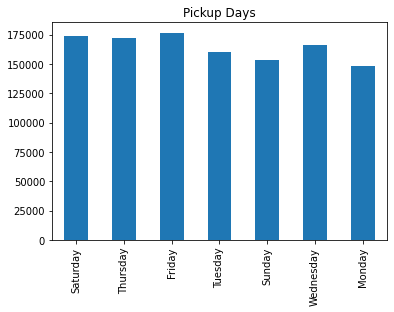

In [110]:
# Pickup Days Histogram
keys = list(train_df["pickup_day_name"].unique())
values = [train_df[train_df["pickup_day_name"]==day].shape[0] for day in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Pickup Days")

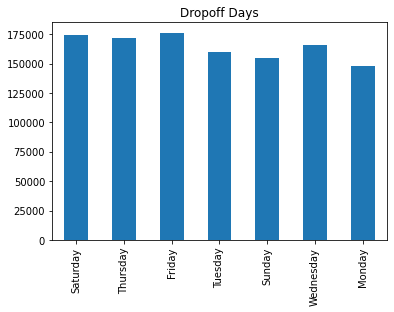

In [111]:
# Dropoff Days Histogram
keys = list(train_df["dropoff_day_name"].unique())
values = [train_df[train_df["dropoff_day_name"]==day].shape[0] for day in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Dropoff Days")

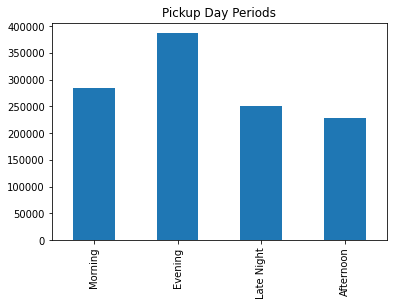

In [112]:
# Pickup Day Period Histogram
keys = list(train_df["pickup_day_period"].unique())
values = [train_df[train_df["pickup_day_period"]==day_period].shape[0] for day_period in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Pickup Day Periods")

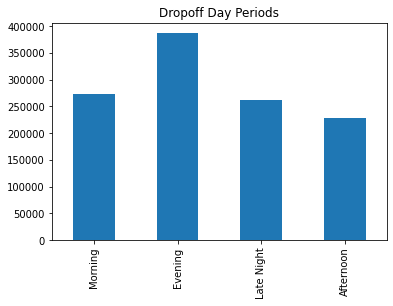

In [113]:
# Dropoff Day Period Histogram
keys = list(train_df["dropoff_day_period"].unique())
values = [train_df[train_df["dropoff_day_period"]==day_period].shape[0] for day_period in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Dropoff Day Periods")

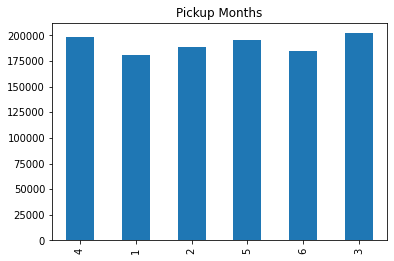

In [114]:
# Pickup Months Histogram
keys = list(train_df["pickup_month"].unique())
values = [train_df[train_df["pickup_month"]==day_period].shape[0] for day_period in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Pickup Months")

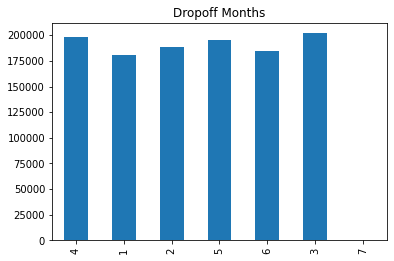

In [115]:
# Dropoff Months Histogram
keys = list(train_df["dropoff_month"].unique())
values = [train_df[train_df["dropoff_month"]==day_period].shape[0] for day_period in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Dropoff Months")

Text(0.5, 1.0, 'Mean Trip duration per Pickup hour')

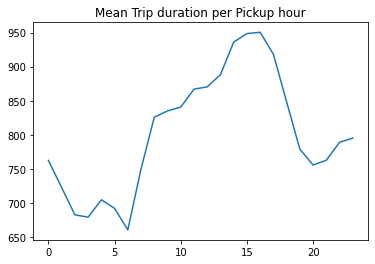

In [116]:
keys = [x for x in range(0,24)]
tmp_df = train_df[["pickup_datetime", "trip_duration"]].copy()
tmp_df["pickup_datetime"] = tmp_df["pickup_datetime"].apply(get_hour)
values = [tmp_df[tmp_df["pickup_datetime"] == hour]["trip_duration"].mean() for hour in keys]
plt.plot(keys, values)
plt.title("Mean Trip duration per Pickup hour")

Text(0.5, 1.0, 'Mean Trip duration per pickup day period')

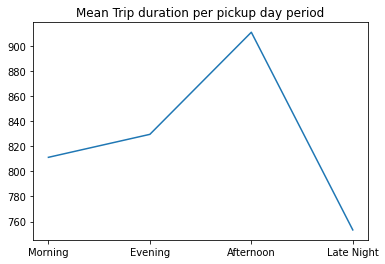

In [117]:
keys = ["Morning", "Evening", "Afternoon", "Late Night"]
values = [train_df[train_df["pickup_day_period"] == period]["trip_duration"].mean() for period in keys]
plt.plot(keys, values)
plt.title("Mean Trip duration per pickup day period")

Text(0.5, 1.0, 'Mean Trip duration per pickup day of week')

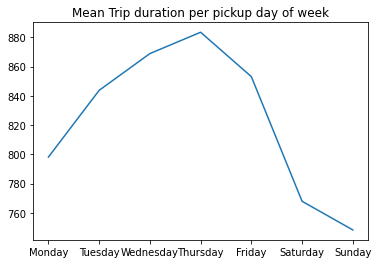

In [118]:
keys = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
values = [train_df[train_df["pickup_day_name"] == day]["trip_duration"].mean() for day in keys]
plt.plot(keys, values)
plt.title("Mean Trip duration per pickup day of week")

## 4 Trip duration histograms

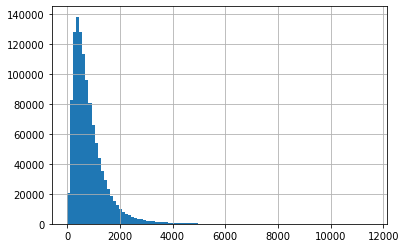

In [119]:
# Train
train_df["trip_duration"].hist(bins=100)

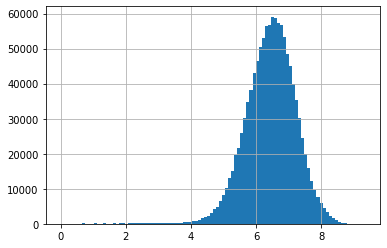

In [120]:
# Train
train_df["log_trip_duration"] = np.log(train_df["trip_duration"])
train_df["log_trip_duration"].hist(bins=100)

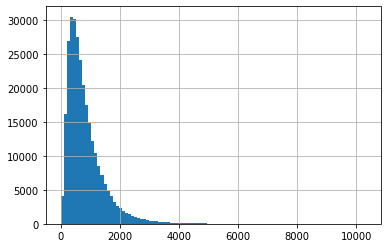

In [121]:
# Test
test_df["trip_duration"].hist(bins=100)

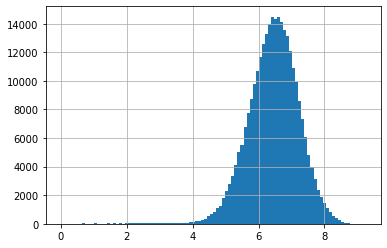

In [122]:
# Test
test_df["log_trip_duration"] = np.log(test_df["trip_duration"])
test_df["log_trip_duration"].hist(bins=100)

## 5

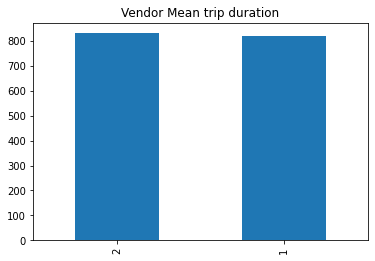

In [123]:
# Mean trip duration per vendor bar plot
keys = list(train_df["vendor_id"].unique())
values = [train_df[train_df["vendor_id"]==vendor]["trip_duration"].mean() for vendor in keys]
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Vendor Mean trip duration")

## 6 Passenger Count

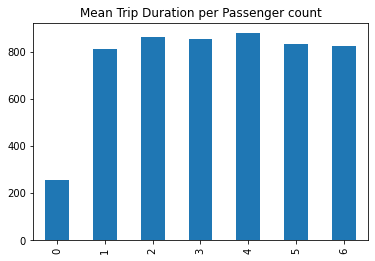

In [124]:
keys = [x for x in range(0,7)]
values = train_df.groupby(["passenger_count"])["trip_duration"].mean()
dic = dict(zip(keys, values))
pd.DataFrame.from_dict(dic, orient='index').plot(kind='bar', legend=False, title="Mean Trip Duration per Passenger count")

## 7 Manhattan Distances

In [125]:
from sklearn.metrics.pairwise import manhattan_distances

def manh_distance(df):
  return manhattan_distances([[df["pickup_latitude"],df["pickup_longitude"]]], [[df["dropoff_latitude"],df["dropoff_longitude"]]])

def get_inner(value):
  return value[0][0]

In [126]:
# Create Manhattan distance column
train_df["m_distance"] = train_df[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].apply(manh_distance, axis=1).apply(get_inner)
test_df["m_distance"] = test_df[["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude"]].apply(manh_distance, axis=1).apply(get_inner)
# Convert degrees to meters, considering each degree is aporoximately 60 miles(since latitude is 69 miles and longitude 54 miles) and each mile is 1600 meters
train_df["m_distance"] = train_df["m_distance"] * 60 * 1600
train_df.drop(train_df.index[train_df["m_distance"] == 0.0], inplace=True) # drop trips with no movement
test_df["m_distance"] = test_df["m_distance"] * 60 * 1600
test_df.drop(test_df.index[test_df["m_distance"] == 0.0], inplace=True) # drop trips with no movement

Text(0.5, 1.0, 'Train Mean Manhattan Distance per pickup day of week')

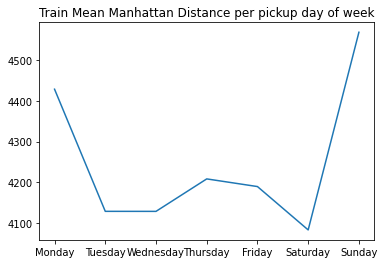

In [127]:
keys = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
values = [train_df[train_df["pickup_day_name"] == day]["m_distance"].mean() for day in keys]
plt.plot(keys, values)
plt.title("Train Mean Manhattan Distance per pickup day of week")

Text(0.5, 1.0, 'Test Mean Manhattan Distance per pickup day of week')

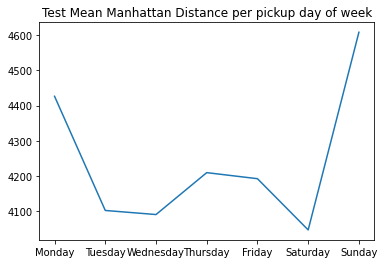

In [128]:
values = [test_df[test_df["pickup_day_name"] == day]["m_distance"].mean() for day in keys]
plt.plot(keys, values)
plt.title("Test Mean Manhattan Distance per pickup day of week")

Text(0.5, 1.0, 'Mean Trip duration based on Km of Manhattan Distance')

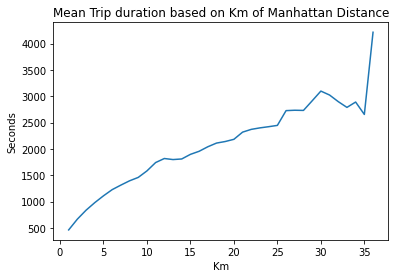

In [129]:
def getInt_Mdistance(md):
  return int(md/1000)

tmp_df = train_df[["m_distance", "trip_duration"]].copy()
tmp_df["d_bin"] = tmp_df["m_distance"].apply(getInt_Mdistance) # Just to create categories based on km of m_distances

keys = [x for x in range(1,tmp_df["d_bin"].max()+1)]
values = [tmp_df[tmp_df["d_bin"] == km]["trip_duration"].mean() for km in keys]

plt.plot(keys, values)
plt.xlabel("Km")
plt.ylabel("Seconds")
plt.title("Mean Trip duration based on Km of Manhattan Distance")

## 8 Μέση ταχύτητα

In [130]:
tmp_df = train_df[["trip_duration","m_distance", "pickup_day_name", "pickup_month", "pickup_datetime"]].copy()
tmp_df["hour"] = tmp_df["pickup_datetime"].apply(get_hour)
tmp_df["speed"] = (tmp_df["m_distance"] / tmp_df["trip_duration"]) / 1000 * 3600 # km/h

Text(0.5, 1.0, 'Mean Speed for each hour')

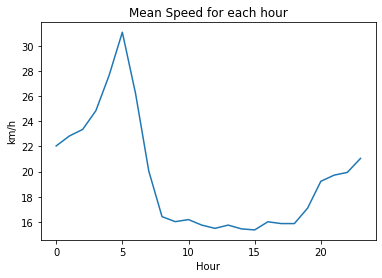

In [131]:
keys = [x for x in range(0,24)]
values = [tmp_df[tmp_df["hour"] == h]["speed"].mean() for h in keys]

plt.plot(keys, values)
plt.xlabel("Hour")
plt.ylabel("km/h")
plt.title("Mean Speed for each hour")

Text(0.5, 1.0, 'Mean Speed for each day')

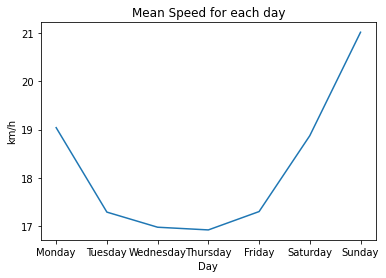

In [132]:
keys = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
values = [tmp_df[tmp_df["pickup_day_name"] == day]["speed"].mean() for day in keys]

plt.plot(keys, values)
plt.xlabel("Day")
plt.ylabel("km/h")
plt.title("Mean Speed for each day")

Text(0.5, 1.0, 'Mean Speed for each Month')

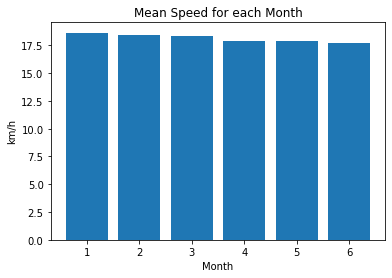

In [133]:
keys = list(train_df["pickup_month"].unique())
values = [tmp_df[tmp_df["pickup_month"] == m]["speed"].mean() for m in keys]

plt.bar(keys, values)
plt.xlabel("Month")
plt.ylabel("km/h")
plt.title("Mean Speed for each Month")

## 9 Scatter plot

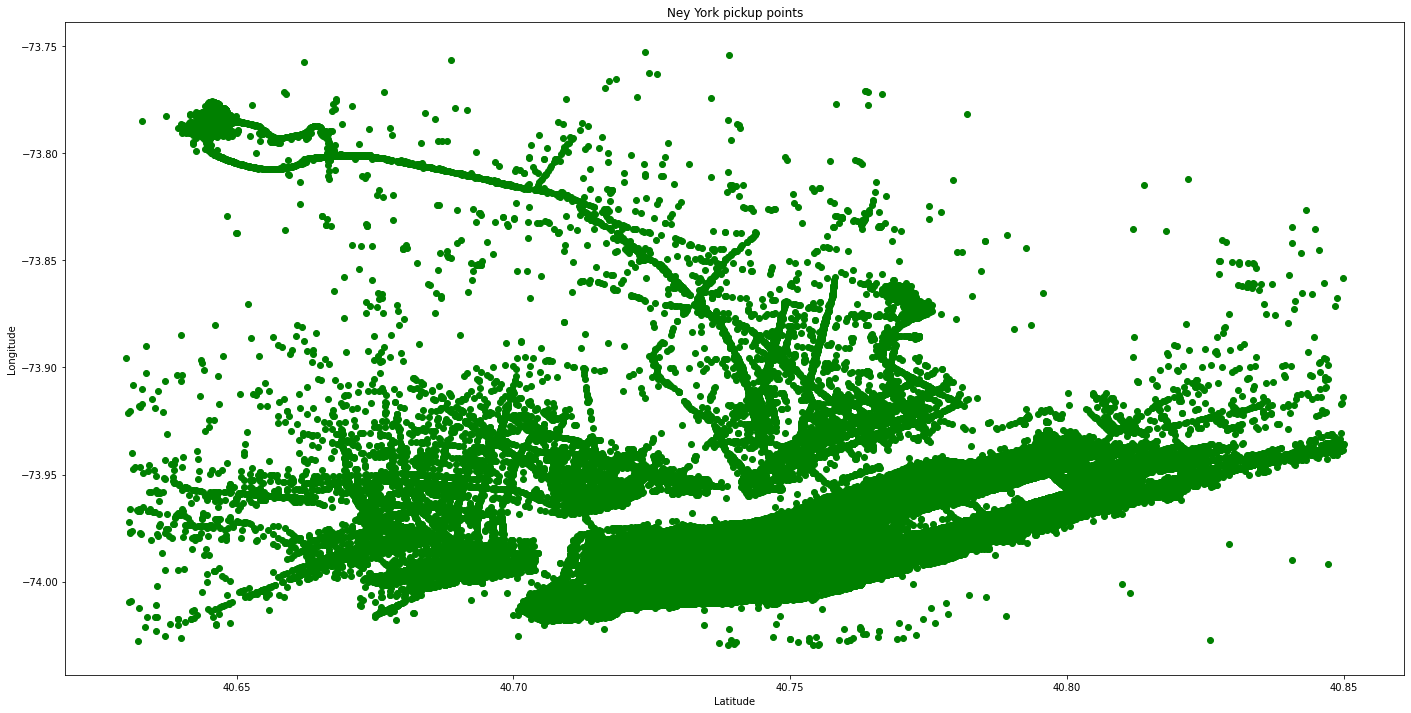

In [134]:
y = train_df["pickup_longitude"]
x = train_df["pickup_latitude"]

plt.figure(figsize=(24, 12))
plt.title("Ney York pickup points")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(x,y, c='green')

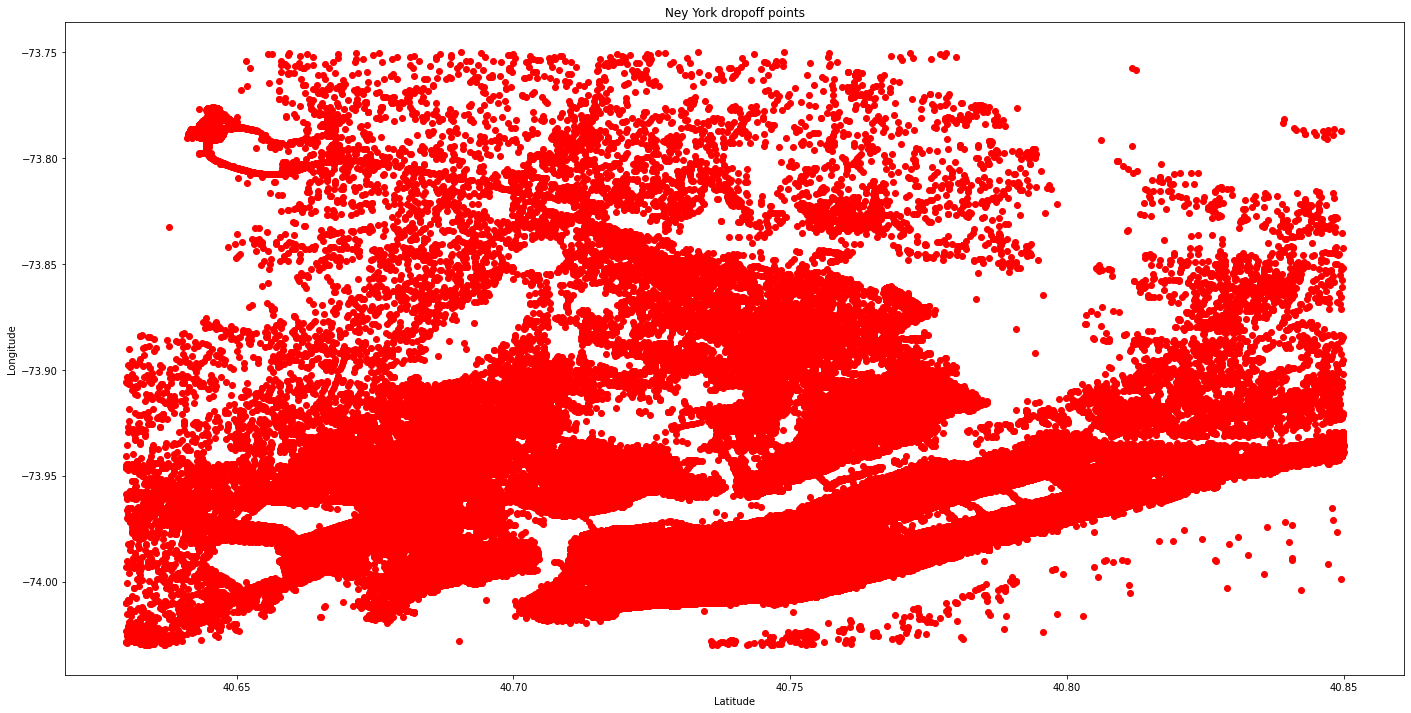

In [135]:
y = train_df["dropoff_longitude"]
x = train_df["dropoff_latitude"]

plt.figure(figsize=(24, 12))
plt.title("Ney York dropoff points")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.scatter(x,y, c='red')

# 2.Συσταδοποίηση και Πρόβλεψη Διάρκειας Ταξιδιού

## 1 Κ-Means

Εφαρμογή μεθόδου elbow

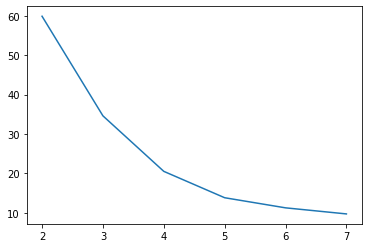

In [136]:
def calculate_sse(kmeans, X) :
  
  i = 0
  total = 0
  centers = kmeans.cluster_centers_
  
  for point in X:
    closest_cluster_center = centers[kmeans.labels_[i]]
    total += np.square(X[i] - closest_cluster_center).sum()
    i += 1

  return total

from sklearn.cluster import KMeans
from os.path import exists
import pickle

usePickleFiles = False #not using pickle file helps with not using more RAM than Google Colab provides.
K_max = 7
X = train_df[['pickup_longitude', 'pickup_latitude']].to_numpy()
dump_path = 'drive/MyDrive/ΤΕΔ/Main Branch/scr/dumps'
models = []

#keep 5% of training set
X = X[:int(len(X)*0.05)]

for K in range(2, K_max+1):
  path = dump_path + '/kmeans' + str(K) + '.pkl'
  if not exists(path):
    # print('here ', K)
    model = KMeans(n_clusters = K).fit(X)
    models.append(model)
    if usePickleFiles:
      pickle.dump(model, open(path, "wb"))
    # print('file ' + path + ' does NOT exist')
  else:
    if usePickleFiles:
      model = pickle.load(open(path, "rb"))
      models.append(model)
      # print('file ' + path + ' does exist')

xAxis = [x for x in range(2,K_max+1)]
yAxis = [calculate_sse(models[i-2], X) for i in range(2, K_max+1)]

plt.plot(xAxis, yAxis)


Βλέπουμε ότι στον 'αγκώνα' του γραφήματος είναι το 5

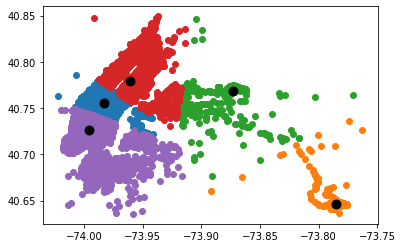

In [137]:
# X = train_df[['pickup_longitude', 'pickup_latitude']].to_numpy()
# kmeans = KMeans(n_clusters = 5)
K_best = 5
path = dump_path + '/kmeans' + str(K_best) + '.pkl'
if exists(path) and usePickleFiles :
  model = pickle.load(open(path, "rb"))
else:
  model = models[K_best - 2]

#predict the labels of clusters.
label = model.predict(X)
 
#Getting unique labels and centroids
centroids = model.cluster_centers_
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(X[label == i , 0] , X[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
# plt.legend()
plt.show()

Παρατηρούμε ότι 3 από τα 5 κεντροειδή είναι κοντά μεταξύ τους, κάτι που λογικά είναι αποτέλεσμα της αρχικής τυχαίας ανάθεσης τους στον χώρο.

## 2 Feature Importances

Εκπαιδεύουμε αρχικά έναν default RandomForestRegressor

In [138]:
from sklearn.ensemble import RandomForestRegressor
import joblib

#initial features: X_all = train_df[['passenger_count',  'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'pickup_season', 'pickup_day_name', 'pickup_day_period', 'm_distance']]

X_all = train_df[['pickup_day_name', 'pickup_day_period', 'm_distance']]
Y_all = train_df['log_trip_duration']

#Change Days to number
X_all.loc[X_all['pickup_day_name'] == 'Monday', 'pickup_day_name'] = 1
X_all.loc[X_all['pickup_day_name'] == 'Tuesday', 'pickup_day_name'] = 2
X_all.loc[X_all['pickup_day_name'] == 'Wednesday', 'pickup_day_name'] = 3
X_all.loc[X_all['pickup_day_name'] == 'Thursday', 'pickup_day_name'] = 4
X_all.loc[X_all['pickup_day_name'] == 'Friday', 'pickup_day_name'] = 5
X_all.loc[X_all['pickup_day_name'] == 'Saturday', 'pickup_day_name'] = 6
X_all.loc[X_all['pickup_day_name'] == 'Sunday', 'pickup_day_name'] = 7

#Change day period to number
X_all.loc[X_all['pickup_day_period'] == 'Morning', 'pickup_day_period'] = 1
X_all.loc[X_all['pickup_day_period'] == 'Afternoon', 'pickup_day_period'] = 2
X_all.loc[X_all['pickup_day_period'] == 'Evening', 'pickup_day_period'] = 3
X_all.loc[X_all['pickup_day_period'] == 'Late Night', 'pickup_day_period'] = 4


#keep 5% of training set
X = X_all[:int(len(X_all)*0.05)]
Y = Y_all[:int(len(Y_all)*0.05)]

path = dump_path + '/default_rf.pkl'
if exists(path) and usePickleFiles:
  print('default rf does exist')
  if usePickleFiles:
    regr = pickle.load(open(path,"rb"))
else:
  print('default rf does NOT exist')
  regr = RandomForestRegressor()
  regr.fit(X, Y)
  if usePickleFiles:
    pickle.dump(regr, open(path, "wb"))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


default rf does NOT exist


Παρουσιάζουμε τα feature importances

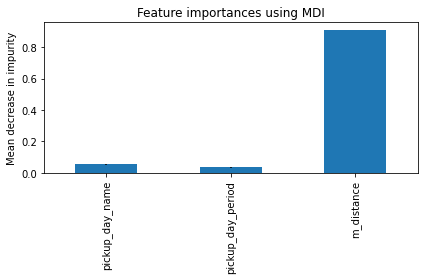

In [139]:
importances = regr.feature_importances_
feature_names = ['pickup_day_name', 'pickup_day_period', 'm_distance']
taxi_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)

fig, ax = plt.subplots()
taxi_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Συμπερένουμε από το γράφημα ότι το πιο σημαντικό χαρακτηριστικό για τον καθορισμό του χρόνου της διαδρομής είναι η απόσταση manhattan.

## 3 GridSearchCV

Χρησιμοποιούμε την GridSearchCV για να βρούμε τις βέλτιστες τιμές των max_depth, max_features, n_estimetors

In [140]:
from sklearn.model_selection import GridSearchCV

#                   Input To GridSearchCV               ->   Result.best_params_
#------------------------------------------------------- | -----------------------
# [10, 20, 30, 40] X ['auto', 'sqrt'] X [100, 150, 200] -> [40] X ['sqrt'] X [150]
# [35, 40, 45, 50] X ['log2', 'sqrt'] X [120, 150, 180] -> [35] X ['sqrt'] X [150]

myGrid = {
    'max_depth': [32, 34, 36, 38],
    'max_features': ['sqrt'],
    'n_estimators': [135, 150, 165]
}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid = myGrid)
grid_search.fit(X[:3000], Y[:3000])

print(grid_search.best_params_)

{'max_depth': 38, 'max_features': 'sqrt', 'n_estimators': 165}


## 4 Εκπαίδευση Random Forest Regressor

Εκπαιδεύουμε το μοντέλο βάσει τα προηγούμενα αποτελέσματα

In [141]:
X = X_all
Y = Y_all

path = dump_path + '/final_rf.pkl'
if exists(path) and usePickleFiles:
  print('final rf does exist')
  final_rf = pickle.load(open(path, "rb"))
else:
  print('final rf does NOT exist')
  final_rf = RandomForestRegressor(n_estimators = 135, max_depth = 32, max_features = 'sqrt')
  final_rf.fit(X, Y)
  if usePickleFiles:
    pickle.dump(final_rf, open(path, "wb"))

final rf does NOT exist


## 5 Πρόβλεψη

Κάνουμε την πρόβλεψη

In [ ]:
T = test_df[['pickup_day_name', 'pickup_day_period', 'm_distance']]

#Change Days to number
T.loc[T['pickup_day_name'] == 'Monday', 'pickup_day_name'] = 1
T.loc[T['pickup_day_name'] == 'Tuesday', 'pickup_day_name'] = 2
T.loc[T['pickup_day_name'] == 'Wednesday', 'pickup_day_name'] = 3
T.loc[T['pickup_day_name'] == 'Thursday', 'pickup_day_name'] = 4
T.loc[T['pickup_day_name'] == 'Friday', 'pickup_day_name'] = 5
T.loc[T['pickup_day_name'] == 'Saturday', 'pickup_day_name'] = 6
T.loc[T['pickup_day_name'] == 'Sunday', 'pickup_day_name'] = 7

#Change day period to number
T.loc[T['pickup_day_period'] == 'Morning', 'pickup_day_period'] = 1
T.loc[T['pickup_day_period'] == 'Afternoon', 'pickup_day_period'] = 2
T.loc[T['pickup_day_period'] == 'Evening', 'pickup_day_period'] = 3
T.loc[T['pickup_day_period'] == 'Late Night', 'pickup_day_period'] = 4

prediction = final_rf.predict(T)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Εξετάζουμε το σφάλμα

In [ ]:
target = test_df['log_trip_duration']
d = target - prediction
mse_f = np.mean(d**2)
mae_f = np.mean(abs(d))

print("MAE: ", mae_f)
print("MSE: ", mse_f)

Παρατηρούμε ότι έχουμε σχετικά καλά αποτελέσματα μετά από όλες τις λεπτομέρειες που στρατηγικά αλλάξαμε.<br>
Επίσης παρατηρούμε ότι MSE < MAE, από το οποίο μπορούμε να υποθέσουμε ότι η πλειοψηφία από τα επιμέρους απόλυτα σφάλματα είναι μικρότερα από την μονάδα.